In [1]:
pip install pymannkendall 

  Using cached pymannkendall-1.4.3-py3-none-any.whl.metadata (14 kB)
Using cached pymannkendall-1.4.3-py3-none-any.whl (12 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pymannkendall as mk
from scipy.stats import linregress

# Plot style
plt.style.use("ggplot")

#### User's input

In [3]:
display_names = {
    'DIN': 'DIN',
    'PO4-P': 'TRP',  
    'SiO2': 'SiO2',
    'TOC': 'TOC',
    'TOTN': 'Total N',
    'TOTP/F': 'TDP',
    'TOTP_P': 'Particulate P',
    'TOTP': 'Total P',
    'TSM': 'TSM',
    'UV-Abs. 410nm': 'UV-Abs. 410nm', 
    'UV-Abs. 254nm' : 'UV-Abs. 254nm' 
}

flux_folder = r'../data/river/fluxes'
site_li = ['Drammenselva', 'Glomma', 'Numedalslagen']

daily_flux_dict = {}
for site in site_li:
    file_path = os.path.join(flux_folder, f'daily_fluxes_{site}.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
        daily_flux_dict[site] = df
    else:
        print(f"File for {site} not found.")

# daily_flux_dict

### Plot daily fluxes

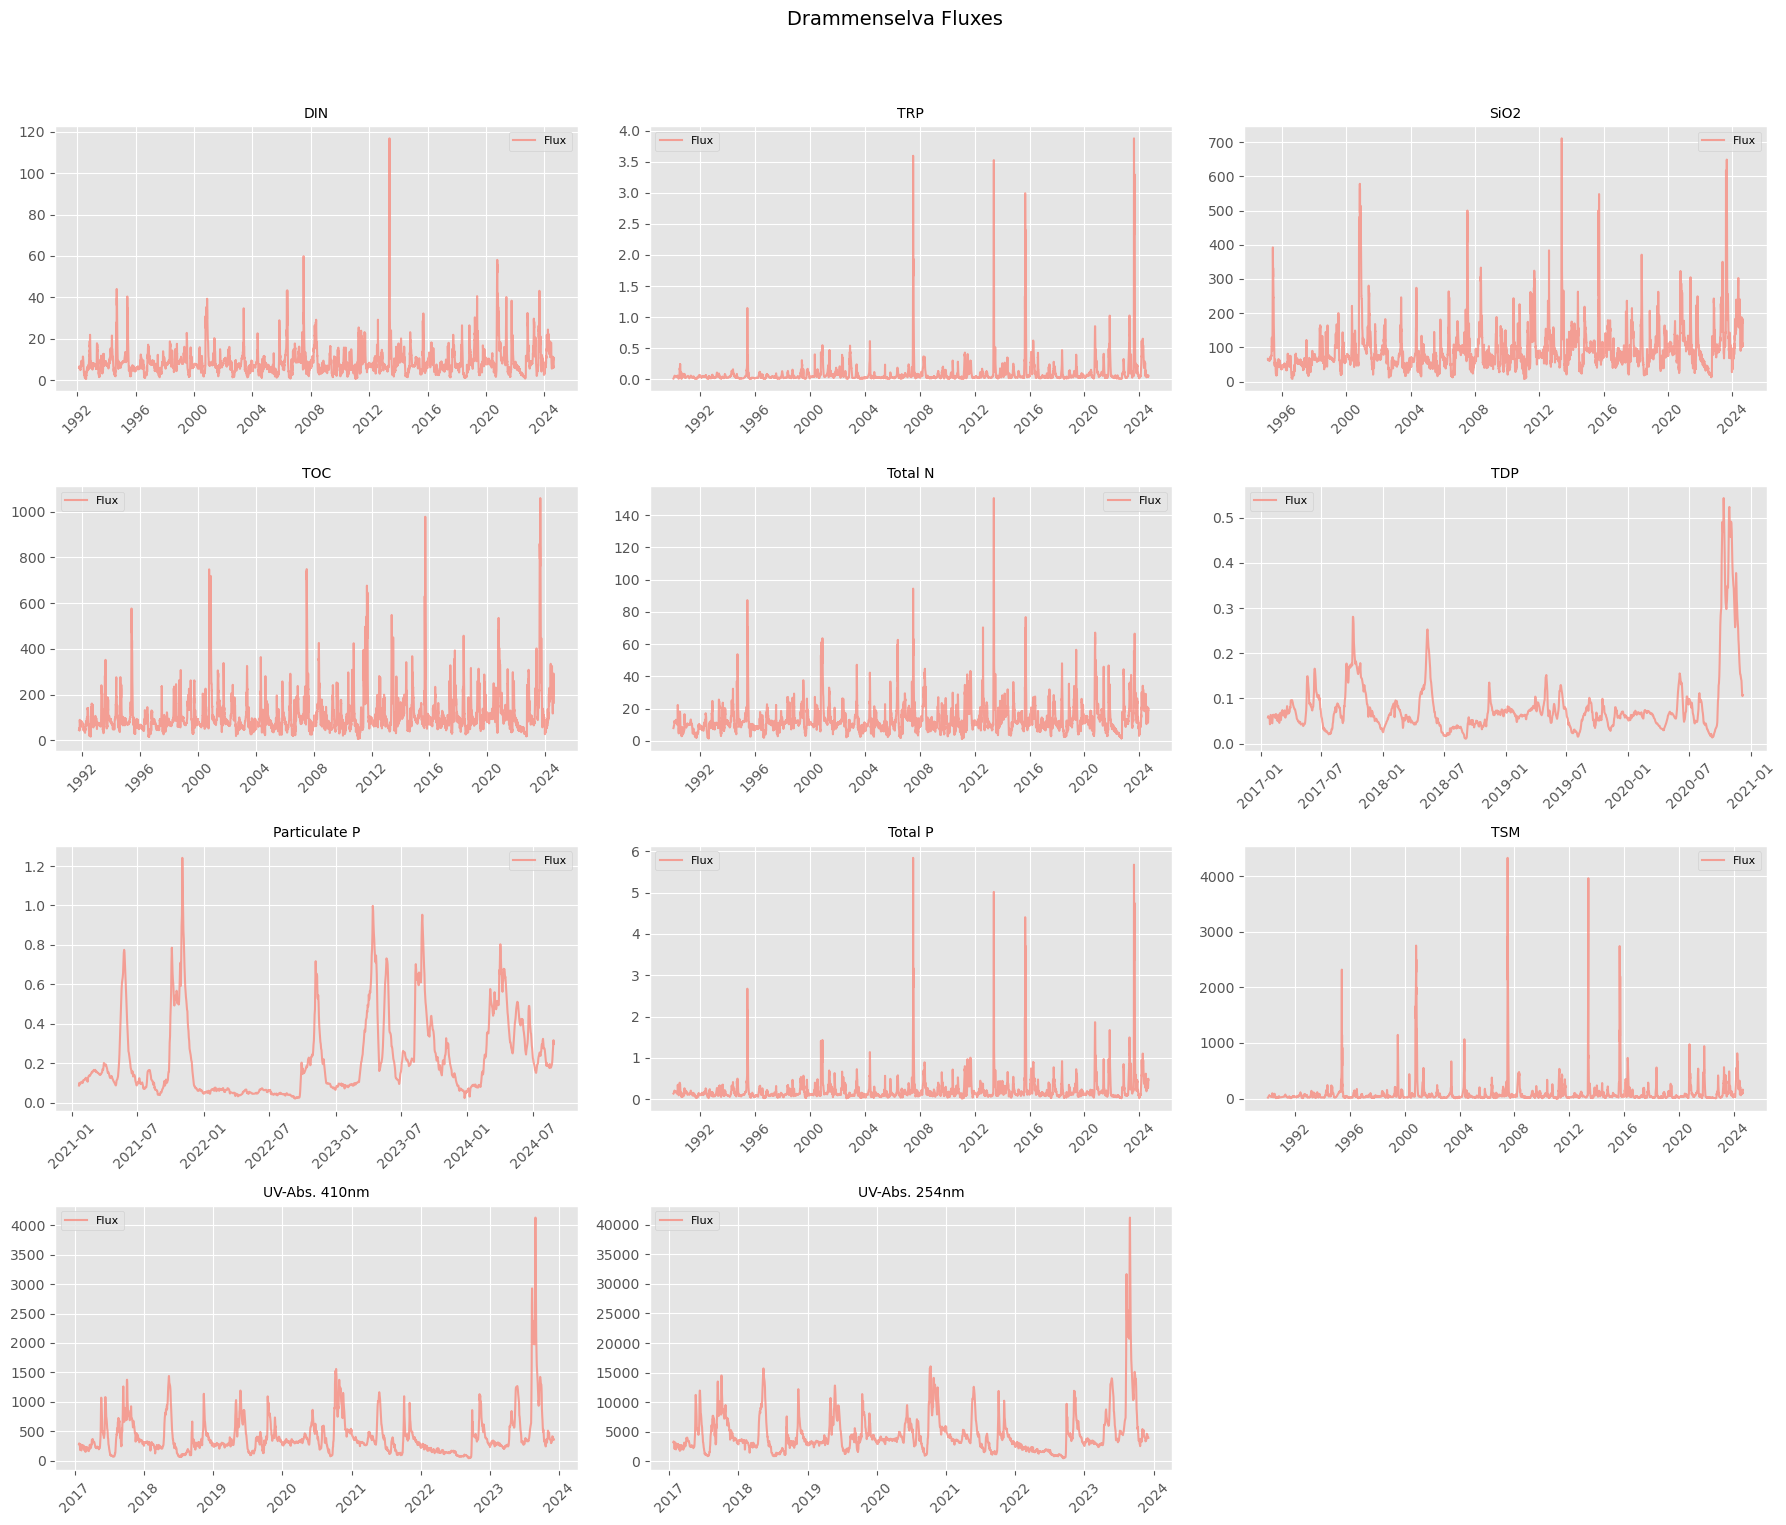

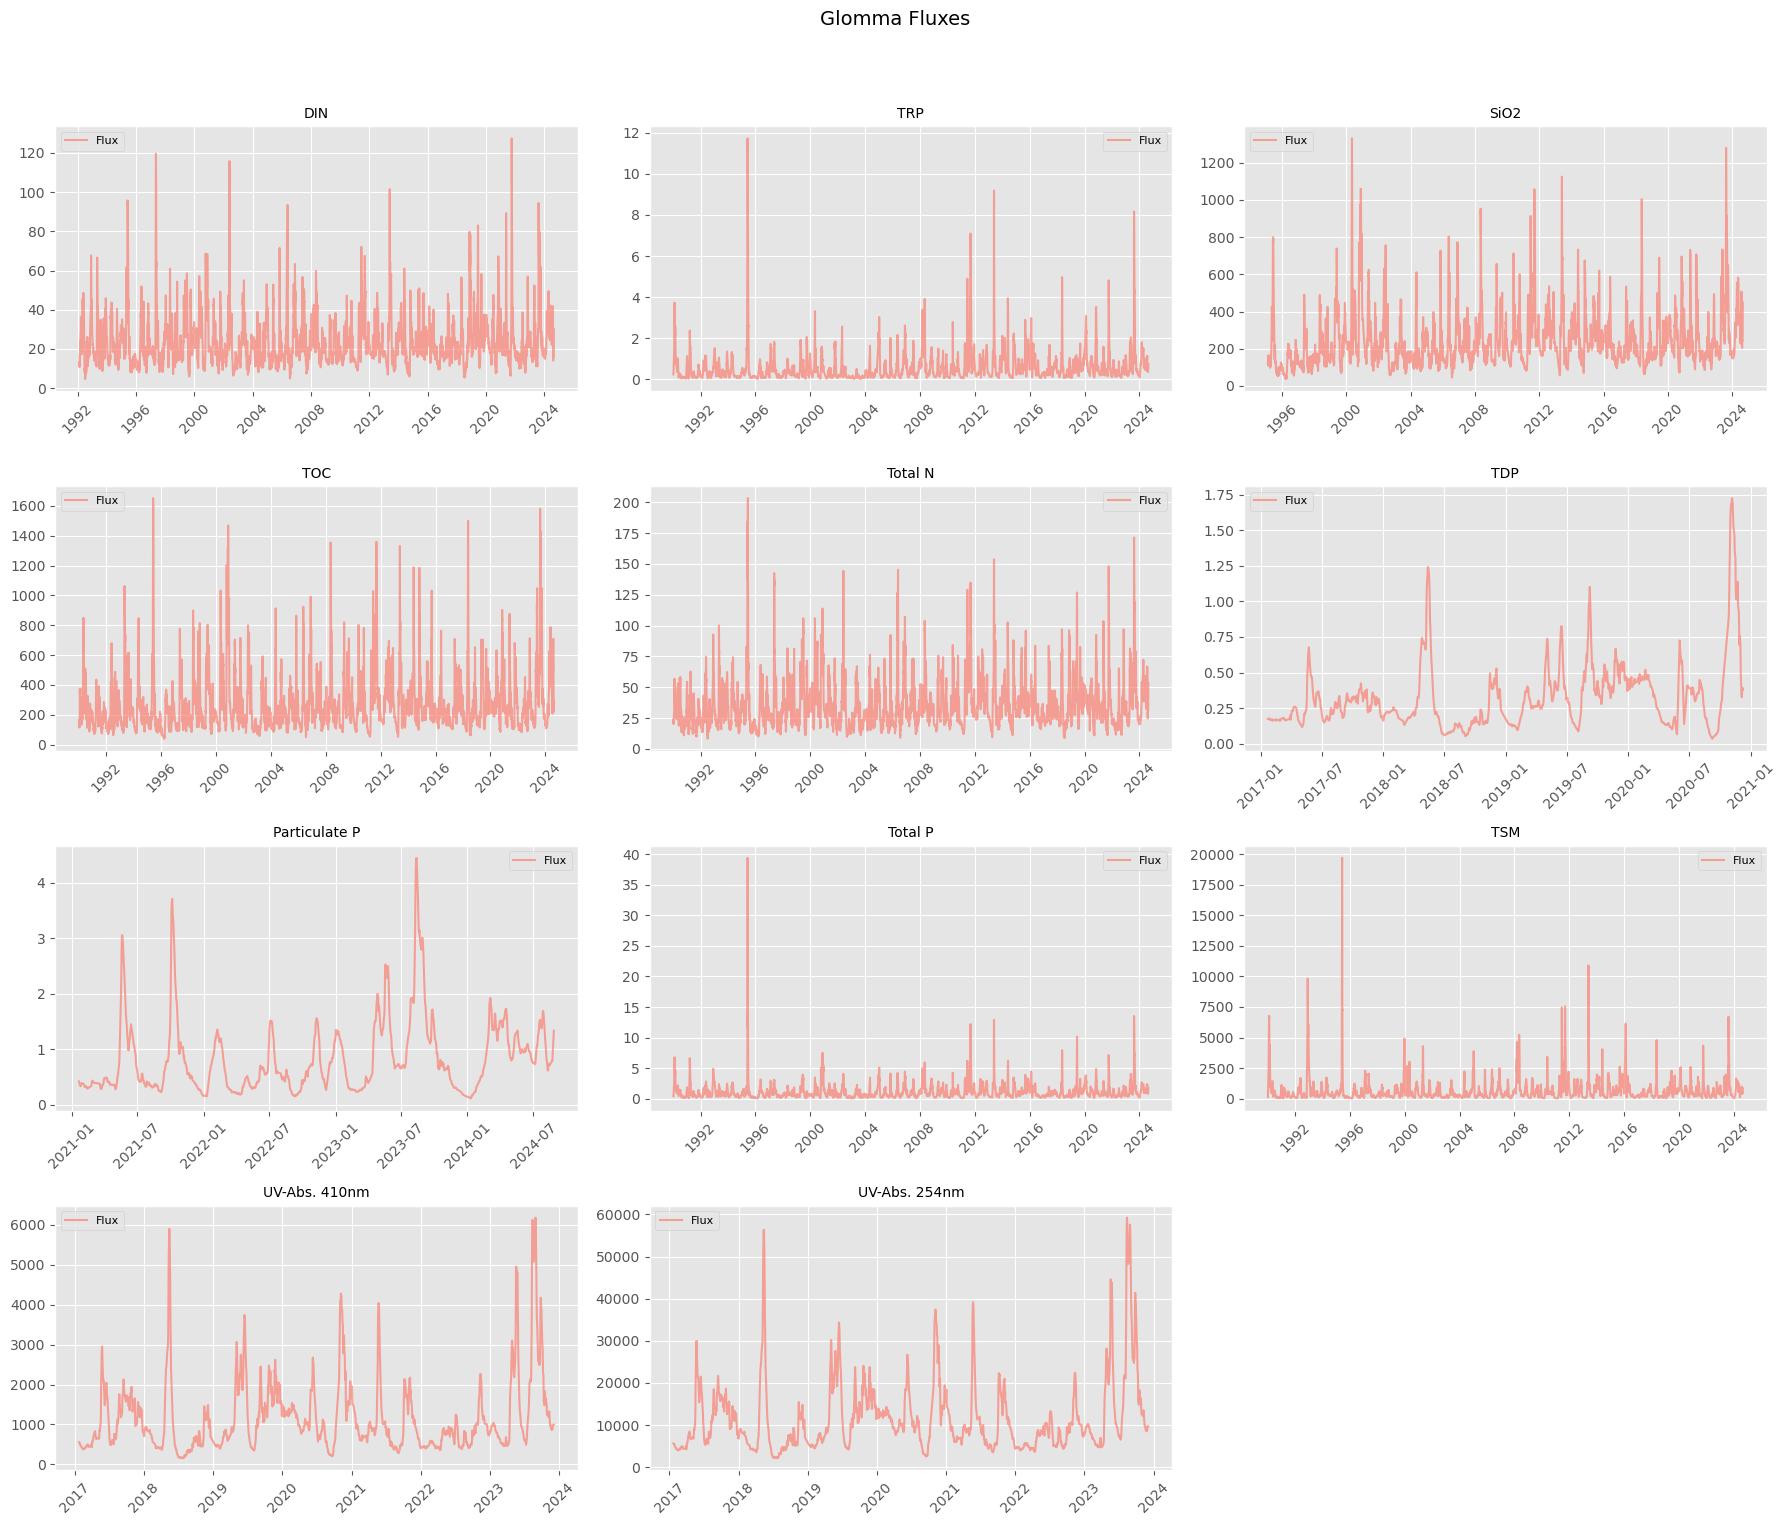

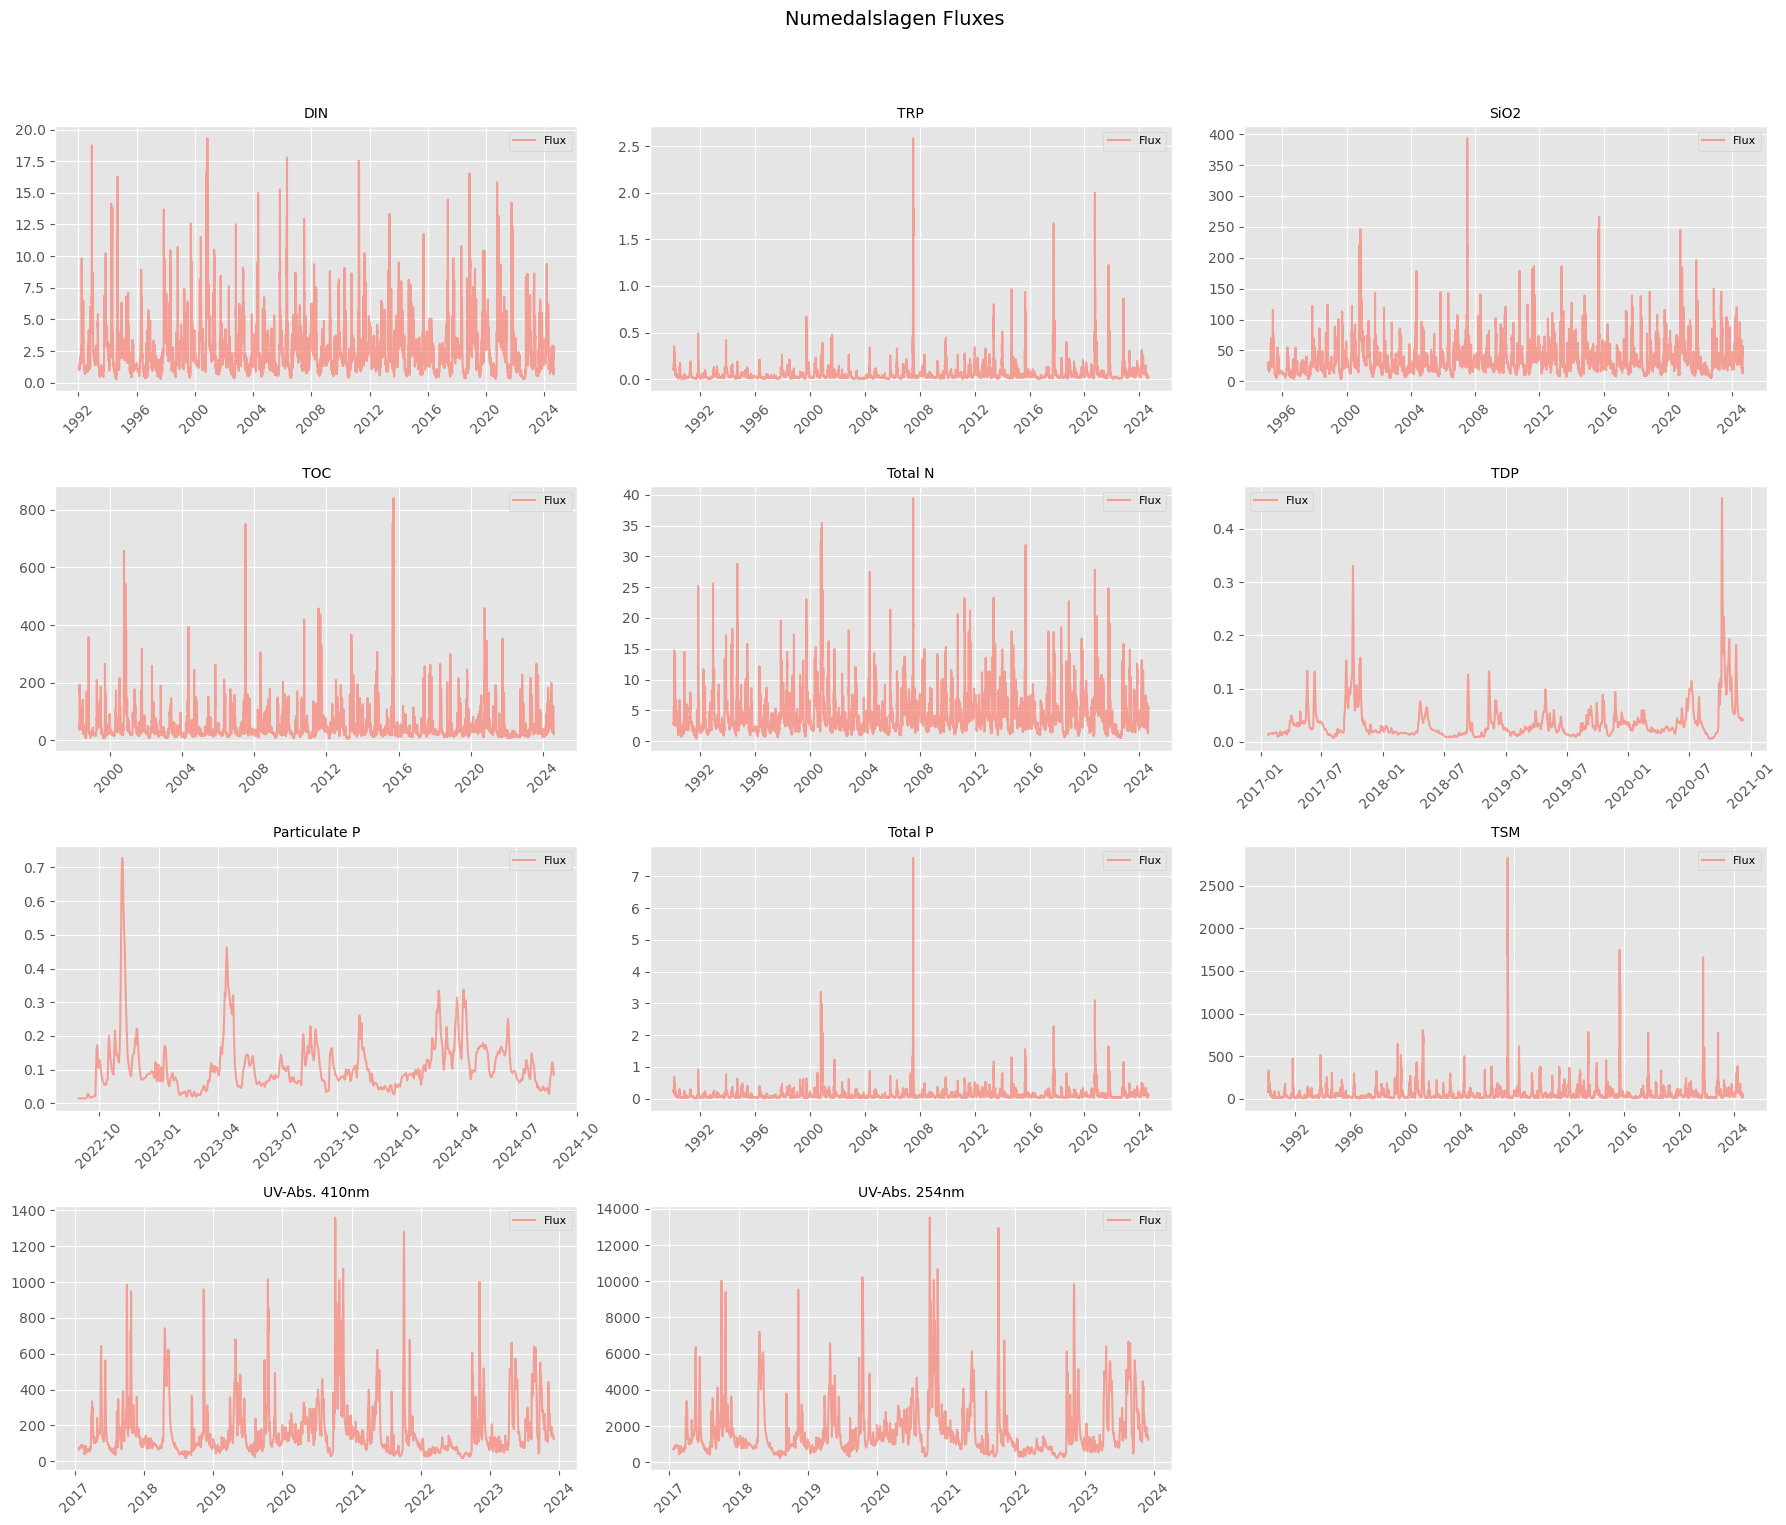

In [4]:
# Plot
for station_name, df_station in daily_flux_dict.items():
    vars_to_plot = list(display_names.keys())
    n_vars = len(vars_to_plot)
    n_cols = 3
    n_rows = math.ceil(n_vars / n_cols)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, var in enumerate(vars_to_plot):
        ax = axes[i]
        flux_col = var

        if flux_col not in df_station.columns:
            continue

        # Plot flux data
        ax.plot(df_station.index, df_station[flux_col],
                label='Flux', linestyle='-', color='salmon', alpha=0.7, zorder=2)

        ax.set_title(display_names.get(var, var), fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)
        ax.legend(fontsize=8)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"{station_name} Fluxes", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [5]:
output_dir = "../plots/rivers/"
os.makedirs(output_dir, exist_ok=True)

for site in site_li:
    df = daily_flux_dict.get(site)
    if df is None:
        continue

    for var, label in display_names.items():
        if var in df.columns:
            plt.figure(figsize=(10, 4))
            plt.plot(df.index, df[var], label=label, color='tab:blue')
            plt.title(f"{site}", fontsize=14)
            plt.ylabel(f"{label}", fontsize=14)
            plt.xlabel("Date")
            plt.grid(True)
            plt.tight_layout()
            safe_var = var.replace('/', '_')
            filename = f"{site}_{safe_var}_flux.png"
            plt.savefig(os.path.join(output_dir, filename), dpi=300)
            plt.close()  

In [6]:
colors = {
    'Drammenselva': 'tab:blue',
    'Glomma': 'tab:green',
    'Numedalslagen': 'tab:orange'
}

for var, label in display_names.items():
    plt.figure(figsize=(12, 4))
    for site in site_li:
        df = daily_flux_dict.get(site)
        if df is not None and var in df.columns:
            plt.plot(df.index, df[var].rolling(30, min_periods=1).mean(), label=site, color=colors[site])
    
    plt.title(" ")
    plt.ylabel(f"{label} [T]")
    plt.xlabel(" ")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"../plots/rivers/river_flux_plots/comparison_{var.replace('/', '_')}.png", dpi=300)
    plt.close()


### Plot annual fluxes and trends 

In [7]:
# Collect annual fluxes per site
annual_flux_dict = {}

for site in site_li:
    df = daily_flux_dict.get(site)
    if df is not None:
        annual_flux_df = df.resample('YE').sum(min_count=350)
        annual_flux_df['Year'] = annual_flux_df.index.year
        annual_flux_dict[site] = annual_flux_df.set_index('Year')

# Loop over variables and generate plots
for var, label in display_names.items():
    fig, ax = plt.subplots(figsize=(10, 5))
    data = pd.DataFrame()

    for site in site_li:
        if site in annual_flux_dict and var in annual_flux_dict[site].columns:
            data[site] = annual_flux_dict[site][var]

    if data.empty:
        continue

    data = data.dropna(how='all')

    # Plot grouped bars
    data.plot(kind='bar', ax=ax, width=0.75)
    ax.set_title(" ")
    ax.set_ylabel(f"{label} [T]")
    ax.set_xlabel(" ")
    ax.legend(title="River")
    ax.grid(True, axis='y')

    # Perform Mann-Kendall test and add trend lines
    for site in data.columns:
        y = data[site].dropna()
        x = y.index
    
        if len(y) >= 5:
            result = mk.original_test(y)
            if result.trend in ['increasing', 'decreasing'] and result.p <= 0.05:
                slope, intercept, _, _, _ = linregress(x, y)
                trend_years = data.index
                trend_vals = slope * trend_years + intercept
                ax.plot(
                    range(len(trend_years)),
                    trend_vals,
                    linestyle='--',
                    label=f"{site} trend ({result.trend}, p={result.p:.3f})"
                )


    plt.tight_layout()
    safe_var = var.replace('/', '_')
    plt.savefig(f"../plots/rivers/river_flux_plots/annual_totals_trend_{safe_var}.png", dpi=300)
    plt.close()
